In [4]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [5]:
# Load dataset
file_path = "/kaggle/input/iot-final-dataset/IotFinalDataset.csv"  # Change path if needed
df = pd.read_csv(file_path)

# Define target column
target_column = 'Label'

# Encode labels (convert categorical labels to numeric)
label_encoder = LabelEncoder()
df[target_column] = label_encoder.fit_transform(df[target_column])

# Select features (exclude target column)
features = [col for col in df.columns if col != target_column]

# Convert to numeric and handle missing values
df[features] = df[features].apply(pd.to_numeric, errors='coerce').fillna(0)

# Standardize numerical features
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

# Split dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target_column], test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Create PyTorch DataLoader
batch_size = 128
train_dataset = data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


In [6]:
# Define Autoencoder architecture
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim=16):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, encoding_dim),
            nn.ReLU()
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded  # Return both encoded and decoded output

# Get input dimension
input_dim = X_train.shape[1]

# Initialize model
autoencoder = Autoencoder(input_dim=input_dim, encoding_dim=16)


In [7]:
# Define loss function and optimizer
criterion = nn.MSELoss()  # Reconstruction loss
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

# Train autoencoder
epochs = 50
for epoch in range(epochs):
    total_loss = 0
    for batch in train_loader:
        X_batch, _ = batch
        optimizer.zero_grad()
        _, decoded = autoencoder(X_batch)
        loss = criterion(decoded, X_batch)  # Compare reconstructed with original input
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")

print("Autoencoder training complete!")


Epoch 1/50, Loss: 0.7307
Epoch 2/50, Loss: 0.7178
Epoch 3/50, Loss: 0.7163
Epoch 4/50, Loss: 0.7156
Epoch 5/50, Loss: 0.7157
Epoch 6/50, Loss: 0.7153
Epoch 7/50, Loss: 0.7153
Epoch 8/50, Loss: 0.7152
Epoch 9/50, Loss: 0.7152
Epoch 10/50, Loss: 0.7152
Epoch 11/50, Loss: 0.7151
Epoch 12/50, Loss: 0.7143
Epoch 13/50, Loss: 0.7142
Epoch 14/50, Loss: 0.7142
Epoch 15/50, Loss: 0.7141
Epoch 16/50, Loss: 0.7141
Epoch 17/50, Loss: 0.7141
Epoch 18/50, Loss: 0.7141
Epoch 19/50, Loss: 0.7141
Epoch 20/50, Loss: 0.7141
Epoch 21/50, Loss: 0.7141
Epoch 22/50, Loss: 0.7141
Epoch 23/50, Loss: 0.7141
Epoch 24/50, Loss: 0.7141
Epoch 25/50, Loss: 0.7141
Epoch 26/50, Loss: 0.7140
Epoch 27/50, Loss: 0.7141
Epoch 28/50, Loss: 0.7141
Epoch 29/50, Loss: 0.7141
Epoch 30/50, Loss: 0.7140
Epoch 31/50, Loss: 0.7141
Epoch 32/50, Loss: 0.7141
Epoch 33/50, Loss: 0.7140
Epoch 34/50, Loss: 0.7140
Epoch 35/50, Loss: 0.7141
Epoch 36/50, Loss: 0.7141
Epoch 37/50, Loss: 0.7141
Epoch 38/50, Loss: 0.7141
Epoch 39/50, Loss: 0.

In [8]:
# Extract compressed features from Autoencoder's encoder
with torch.no_grad():
    X_train_encoded = autoencoder.encoder(X_train_tensor).numpy()
    X_test_encoded = autoencoder.encoder(X_test_tensor).numpy()

# Convert to PyTorch tensors
X_train_encoded_tensor = torch.tensor(X_train_encoded, dtype=torch.float32)
X_test_encoded_tensor = torch.tensor(X_test_encoded, dtype=torch.float32)

# Define classifier model
class Classifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(Classifier, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )
    
    def forward(self, x):
        return self.fc(x)

# Initialize classifier model
num_classes = len(np.unique(y_train))
classifier = Classifier(input_dim=16, num_classes=num_classes)

# Define classifier loss and optimizer
criterion_cls = nn.CrossEntropyLoss()
optimizer_cls = optim.Adam(classifier.parameters(), lr=0.001)

# Train classifier
epochs = 30
for epoch in range(epochs):
    total_loss = 0
    for batch in train_loader:
        X_batch, y_batch = batch
        X_batch_encoded = autoencoder.encoder(X_batch)  # Extract features
        optimizer_cls.zero_grad()
        outputs = classifier(X_batch_encoded)
        loss = criterion_cls(outputs, y_batch)
        loss.backward()
        optimizer_cls.step()
        total_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")

print("Classifier training complete!")


Epoch 1/30, Loss: 0.3711
Epoch 2/30, Loss: 0.3238
Epoch 3/30, Loss: 0.3187
Epoch 4/30, Loss: 0.3155
Epoch 5/30, Loss: 0.3135
Epoch 6/30, Loss: 0.3118
Epoch 7/30, Loss: 0.3101
Epoch 8/30, Loss: 0.3081
Epoch 9/30, Loss: 0.3064
Epoch 10/30, Loss: 0.3042
Epoch 11/30, Loss: 0.3013
Epoch 12/30, Loss: 0.2975
Epoch 13/30, Loss: 0.2941
Epoch 14/30, Loss: 0.2887
Epoch 15/30, Loss: 0.2833
Epoch 16/30, Loss: 0.2767
Epoch 17/30, Loss: 0.2696
Epoch 18/30, Loss: 0.2618
Epoch 19/30, Loss: 0.2521
Epoch 20/30, Loss: 0.2427
Epoch 21/30, Loss: 0.2338
Epoch 22/30, Loss: 0.2239
Epoch 23/30, Loss: 0.2159
Epoch 24/30, Loss: 0.2086
Epoch 25/30, Loss: 0.2018
Epoch 26/30, Loss: 0.1965
Epoch 27/30, Loss: 0.1909
Epoch 28/30, Loss: 0.1858
Epoch 29/30, Loss: 0.1820
Epoch 30/30, Loss: 0.1785
Classifier training complete!


Accuracy: 0.9520

Classification Report:
                    precision    recall  f1-score   support

            Benign       0.98      0.96      0.97     65391
         DNS Flood       0.98      0.99      0.99      9338
 Dictionary Attack       0.99      0.99      0.99      2013
        ICMP Flood       1.00      1.00      1.00     44930
           OS Scan       0.62      0.01      0.02      7700
        Ping Sweep       0.95      0.98      0.96     14358
         Port Scan       0.92      0.99      0.95     88162
         SYN Flood       0.73      0.99      0.84      2817
         Slowloris       1.00      1.00      1.00      3724
         UDP Flood       0.91      0.80      0.85      2015
Vulnerability Scan       0.94      0.97      0.95      8015

          accuracy                           0.95    248463
         macro avg       0.91      0.88      0.87    248463
      weighted avg       0.94      0.95      0.94    248463



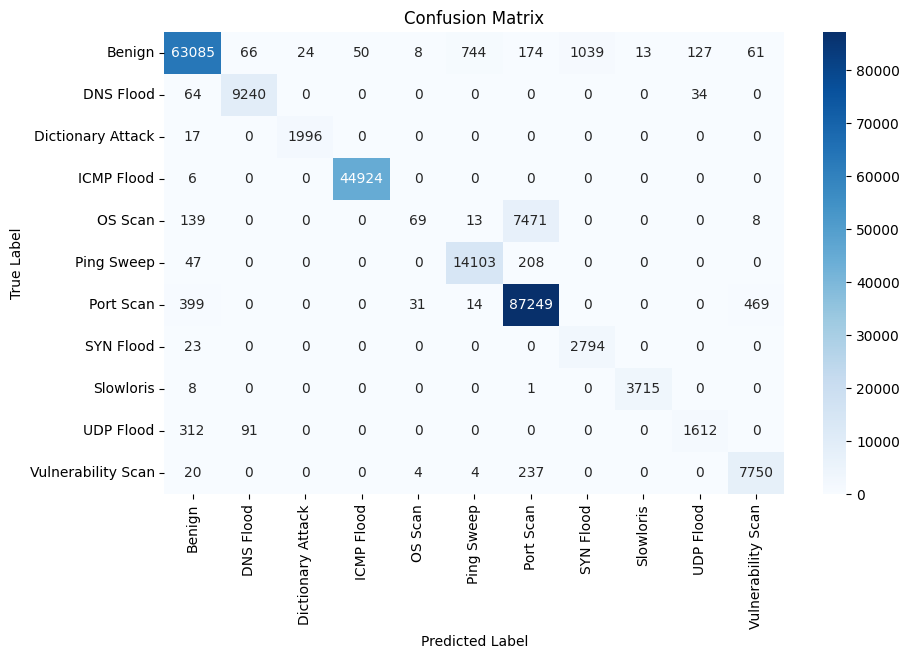

In [9]:
# Predict on test set
with torch.no_grad():
    X_test_encoded = autoencoder.encoder(X_test_tensor)
    y_pred_logits = classifier(X_test_encoded)
    y_pred = torch.argmax(y_pred_logits, dim=1).numpy()

# Compute accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score


In [11]:
# Compute softmax probabilities for predictions
with torch.no_grad():
    y_pred_proba = torch.softmax(y_pred_logits, dim=1).numpy()  # Convert logits to probabilities

# Convert labels to a binary format (one-hot encoding)
num_classes = len(label_encoder.classes_)
y_test_bin = label_binarize(y_test, classes=np.arange(num_classes))

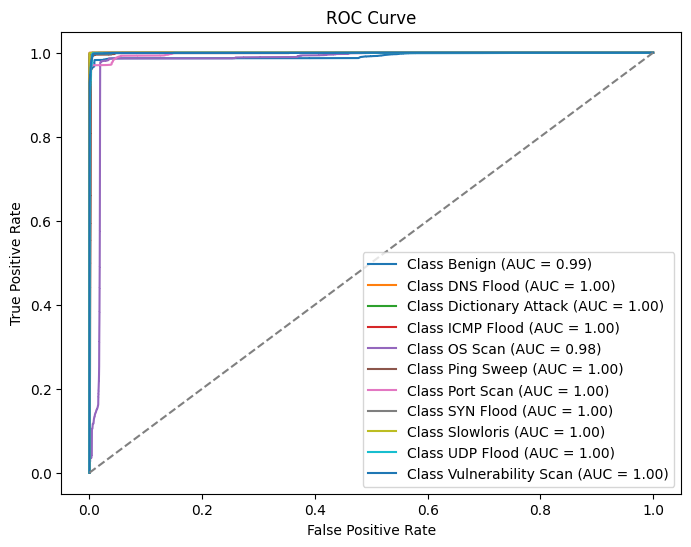

In [12]:
# Plot ROC Curve for each class
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {label_encoder.classes_[i]} (AUC = {roc_auc:.2f})')

# Plot diagonal reference line
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")

# Labels and title
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


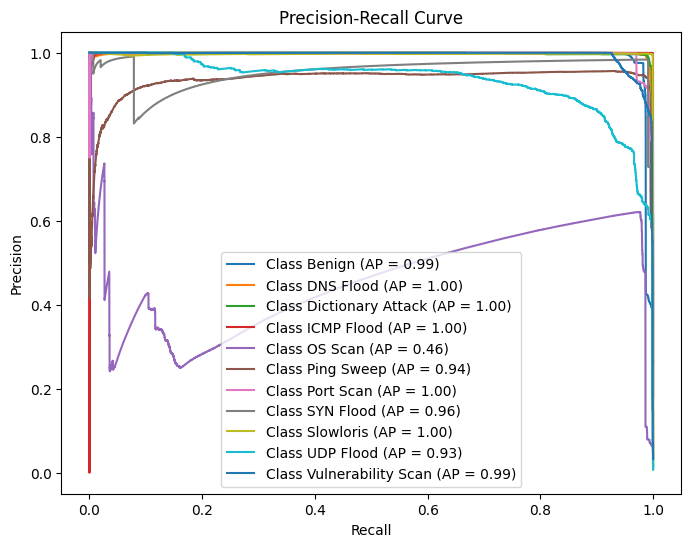

In [13]:
# Plot Precision-Recall Curve for each class
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_pred_proba[:, i])
    ap_score = average_precision_score(y_test_bin[:, i], y_pred_proba[:, i])
    plt.plot(recall, precision, label=f'Class {label_encoder.classes_[i]} (AP = {ap_score:.2f})')

# Labels and title
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()


In [14]:
import torch
import joblib

# Save the trained Autoencoder model
torch.save(autoencoder.state_dict(), "autoencoder_model.pth")

# Save the trained classifier model (if separate from Autoencoder)
torch.save(classifier.state_dict(), "classifier_model.pth")

# Save the StandardScaler used for preprocessing
joblib.dump(scaler, "scaler.pkl")

print("Model and Scaler saved successfully!")


Model and Scaler saved successfully!
